In [1]:
import numpy as np
from scipy import signal
from scipy.io import wavfile
import matplotlib
import matplotlib.pyplot as plt
import math
import warnings; warnings.simplefilter('ignore') # Para quitar mensajes de warning
import upv_audio 
matplotlib.rcParams['figure.figsize'] = (15.0, 7.5)

# Determinación de la frecuencia fundamental
En este cuaderno veremos un procedimiento para estimar la frecuencia fundamental (o lo que es equivalente el periodo) de un fragmento de señal.

La idea con esto sería ser capaz de determinar **qué nota escucharía el oido**.

Ya hemos visto que la componente espectral de mayor amplitud no tiene por qué coincidir con la frecuencia fundamental. Es decir la componente en $2 f_0$ puede tener mayor amplitud que la de $f_0$.

Comenzaremos cargando las 6 cuerdas de la guitarra y seleccionando un fragmento de medio segundo de cada uno de ellos, visualizando los espectros de amplitud y a ver si nos *inspiramos*

[Referencia Harmonic Product Spectrum 1](http://musicweb.ucsd.edu/~trsmyth/analysis/Harmonic_Product_Spectrum.html)

[Guitar tuner](https://www.chciken.com/digital/signal/processing/2020/05/13/guitar-tuner.html)

## Visualización de las señales y sus espectros

In [2]:
#Esto lo dejaremos para cuando lo necesitemos
f_cuerdas  = [329.63, 246.94, 196.00, 146.8, 110, 82.41]
#leemos el audio
fs,x1=upv_audio.read('audios/guitarra/c1.wav')
fs,x2=upv_audio.read('audios/guitarra/c2.wav')
fs,x3=upv_audio.read('audios/guitarra/c3.wav')
fs,x4=upv_audio.read('audios/guitarra/c4.wav')
fs,x5=upv_audio.read('audios/guitarra/c5.wav')
fs,x6=upv_audio.read('audios/guitarra/c6.wav')
print(fs)


44100


In [3]:
# De cuaderno anterior
def espectroFFT(x, NFFT=None):
    
    # Si no damos NFFT es directamente la longitud de la señal
    L=len(x)
    if NFFT==None:
        NFFT = L 
       
    # Comprobamos que NFFT sea mayor que la longitud de x.
    assert L<=NFFT, 'NFFT tiene que ser mayor o igual a que len(x)'

    # Calculamos la FFT. Se rellena con ceros desde L a NFFT 
    X = np.fft.fft(x,NFFT)
   
    A=2/L*np.abs(X)
   
    # Generamos el eje de frecuencia digital
    fd = np.arange(0, NFFT)/NFFT
    
  # Nos quedamos con la primera mitad (hasta frec 0.5)
    A=A[0:NFFT//2]
    fd=fd[0:NFFT//2]
    
    return A,fd 

In [4]:
duracion = int(0.2*fs)

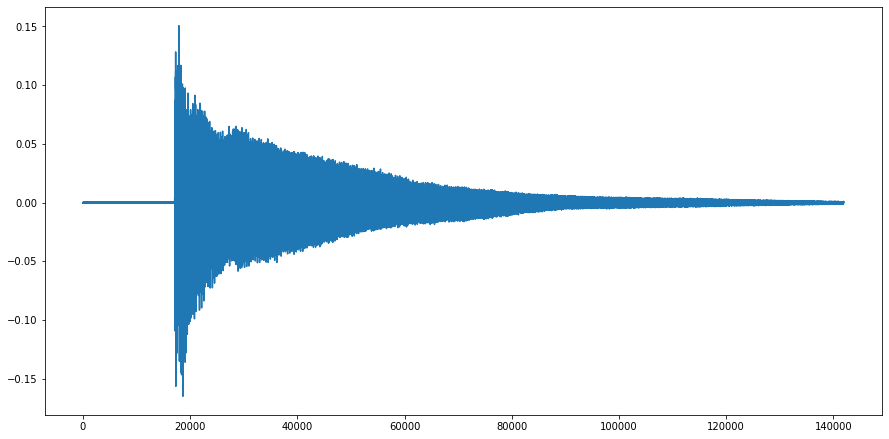

In [5]:
_=plt.plot(x1)

In [8]:
ini1=40000
fin1=ini1+duracion
trozo1=x1[ini1:fin1]

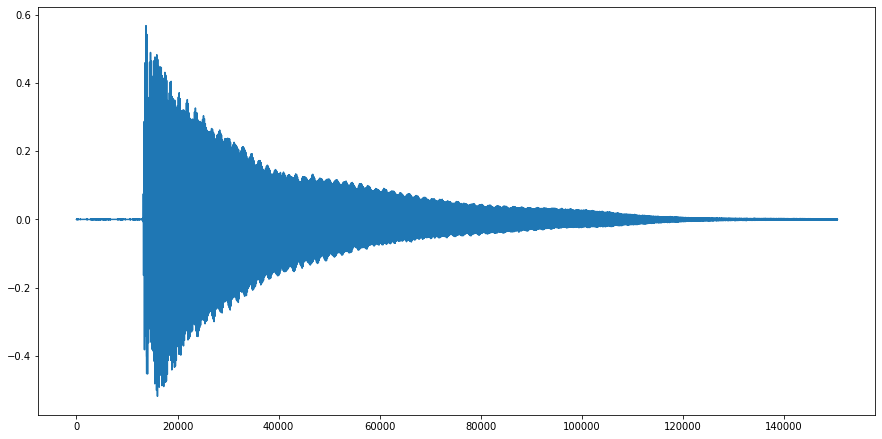

In [9]:
_=plt.plot(x2)
ini2=40000
fin2=ini2+duracion
trozo2=x2[ini2:fin2]

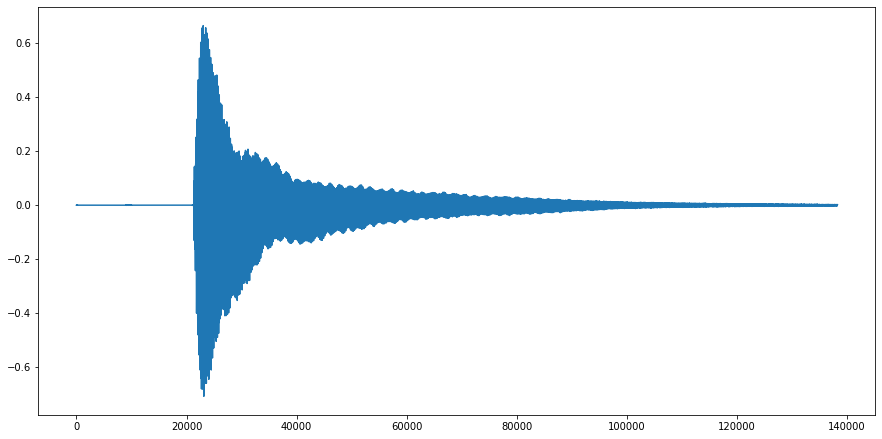

In [10]:
_=plt.plot(x3)
ini3=40000
fin3=ini3+duracion
trozo3=x3[ini3:fin3]

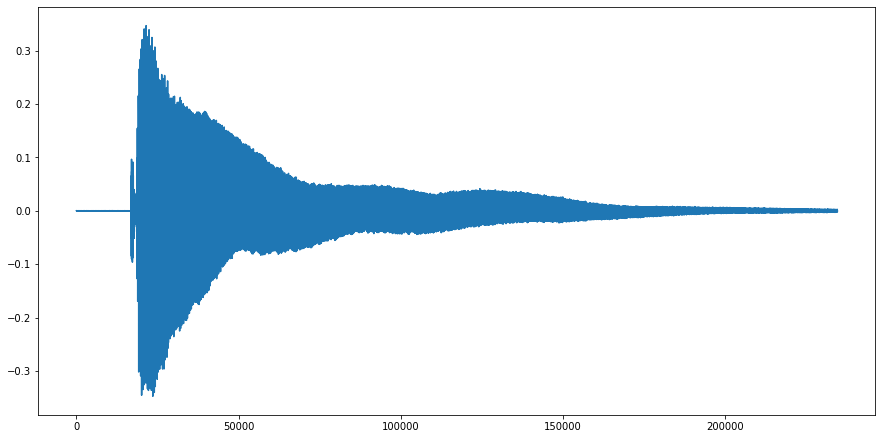

In [11]:
_=plt.plot(x4)
ini4=40000
fin4=ini4+duracion
trozo4=x4[ini4:fin4]

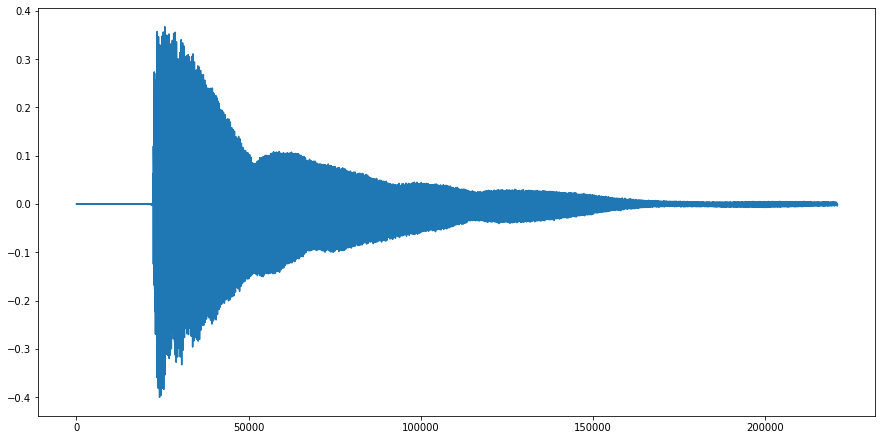

In [12]:
_=plt.plot(x5)
ini5=40000
fin5=ini5+duracion
trozo5=x5[ini5:fin5]

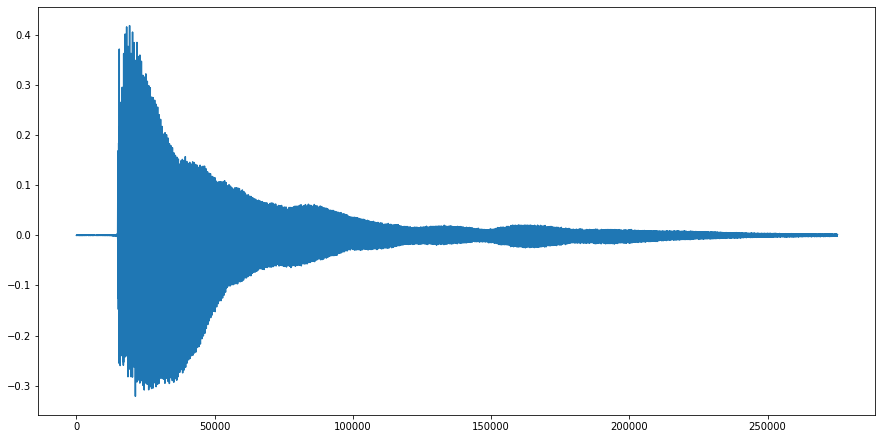

In [13]:
_=plt.plot(x6)
ini6=40000
fin6=ini6+duracion
trozo6=x6[ini6:fin6]

In [17]:
NFFT=2**math.ceil(math.log2(4*len(trozo1)))
X1,f=espectroFFT(trozo1,NFFT)
X2,f=espectroFFT(trozo2,NFFT)
X3,f=espectroFFT(trozo3,NFFT)
X4,f=espectroFFT(trozo4,NFFT)
X5,f=espectroFFT(trozo5,NFFT)
X6,f=espectroFFT(trozo6,NFFT)

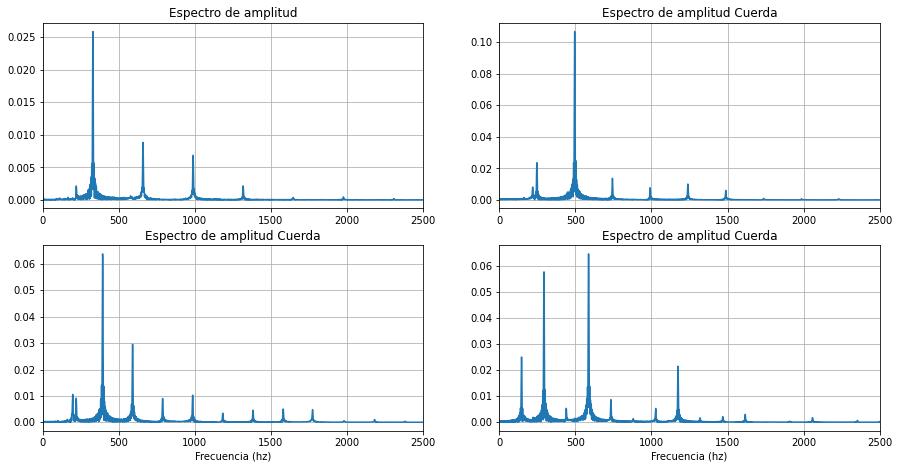

In [24]:
_=plt.subplot(2,2,1)
_=plt.plot(f*fs,X1)
_=plt.xlim((0,2500))
_=plt.title('Espectro de amplitud')
_=plt.grid()

_=plt.subplot(2,2,2)
_=plt.plot(f*fs,X2)
_=plt.xlim((0,2500))

_=plt.title('Espectro de amplitud Cuerda')
_=plt.grid()

_=plt.subplot(2,2,3)
_=plt.plot(f*fs,X3)
_=plt.xlim((0,2500))
_=plt.xlabel('Frecuencia (hz)')
_=plt.title('Espectro de amplitud Cuerda')
_=plt.grid()

_=plt.subplot(2,2,4)
_=plt.plot(f*fs,X4)
_=plt.xlim((0,1500))
_=plt.xlim((0,2500))
_=plt.xlabel('Frecuencia (hz)')
_=plt.title('Espectro de amplitud Cuerda')
_=plt.grid()



**PREGUNTA:** ¿Cuál de las dos curvas es la primera cuerda?

## Observaciones
* Vemos más o menos el mismo patrón en todas las cuerdas
* En general la frecuencia fundamental **NO** es el armónico de más amplitud

# Idea del método
* Supondremos que la frecuencia fundamental está en un rango
* Para cada frecuencia de ese rango sumaremos la potencia los *K* primeros armónicos.
* Elegiremos la frecuencia fundamental que maximice


In [22]:
# Este médodo es peor
def determina_frecuencia_fundamental_sum(X,f_analog,fmin,fmax): 
    '''
    X espectro de amplitudes tal como lo devuelve calculaFFT
    f_analog: f*fs, donde f es frecuencia digital devuelta por calculaFFT
       cada elemento de f_analog es la frecuencia correspondiente del espectro de amplitud.
    
    fmin,fmax, rango de frecuencias fundamentales    '''
    
    #Numero máximo de armónicos a considerar
    K=7
    
    # Calcular los valores de kmin, kmax que corresponden al rango de frecuencias fmin, fmax
    # recordar que kmin y kmax son valores enteros (emplear round)
    kmin = np.max(np.argwhere(f_analog<fmin*K))
    kmax = np.min(np.argwhere(f_analog>fmax*K))
    
    # Recorremos el rango de frecuencias entre kmin y kmax (fmnin y fmax)
    max_val=0
    best_fundamental =0
    for n in np.arange(kmin, kmax):
        
        fundamental = float(n)/float(K)
        ind = fundamental * np.arange(1,K+1) # Índices donde están los armónicos  
        ind = np.round(ind).astype('int')
        val = np.sum((X[ind]**2))  # Sumamos las potencias de los armonicos 
        
        if (val > max_val):
            max_val = val
            best_fundamental = f_analog[n]/K                     
    
    #Devolvemos la frecuencia con la amplitud máxima acumulada
    return best_fundamental, max_val


In [30]:
# Este es mejor si todos los armónicos existen

# REQUIERE EXPLICACION
def determina_frecuencia_fundamental(X,f_analog,fmin,fmax): 
    '''
    X espectro de amplitudes tal como lo devuelve calculaFFT
    f_analog: f*fs, donde f es frecuencia digital devuelta por calculaFFT
       cada elemento de f_analog es la frecuencia correspondiente del espectro de amplitud.
    
    fmin,fmax, rango de frecuencias fundamentales    '''
    
    #Numero máximo de armónicos a considerar
    K=7
    
    # Calcular los valores de kmin, kmax que corresponden al rango de frecuencias fmin, fmax
    # recordar que kmin y kmax son valores enteros (emplear round)
    kmin = np.max(np.argwhere(f_analog<fmin*K))
    kmax = np.min(np.argwhere(f_analog>fmax*K))
    
    # Recorremos el rango de frecuencias entre kmin y kmax (fmnin y fmax)
    max_val=0
    best_fundamental =0
    for n in np.arange(kmin, kmax):
        
        fundamental = float(n)/float(K)
        ind = fundamental * np.arange(1,K+1) # Índices donde están los armónicos  
        ind = np.round(ind).astype('int')
        val = np.prod((X[ind]))  # Multiplicamos las potencias de los armonicos 
        
        if (val > max_val):
            max_val = val
            best_fundamental = f_analog[n]/K                     
    
    #Devolvemos la frecuencia con la amplitud máxima acumulada
    return best_fundamental, max_val


In [24]:
fund1,ampl1=determina_frecuencia_fundamental(X1,f*fs,75,350)
print(fund1)

329.43878173828125


In [25]:
fund2,ampl2=determina_frecuencia_fundamental(X2,f*fs,75,350)
print(fund2)

248.016357421875


In [26]:
fund3,ampl3=determina_frecuencia_fundamental(X3,f*fs,75,350)
print(fund3)

197.16339111328125


In [27]:
fund4,ampl4=determina_frecuencia_fundamental(X4,f*fs,75,350)
print(fund4)

146.79107666015625


In [28]:
fund5,ampl5=determina_frecuencia_fundamental(X5,f*fs,75,350)
print(fund5)
fund6,ampl6=determina_frecuencia_fundamental(X6,f*fs,75,350)
print(fund6)

109.7808837890625
82.38372802734375


In [31]:
f_cuerdas

[329.63, 246.94, 196.0, 146.8, 110, 82.41]

**Observaciones**

* Como se ve se parece bastante a las frecuencias de las respectivas cuerdas
* Haremos una función que dada la frecuencia fundamental devuelva cual es la cuerda más probable y el error en semitonos en la frecuencia

La distancia en semitonos se obtiene mediante la fórmula  $ \Delta f (Semitonos) = 12 \, \left( \log_2 (f_1) - \log _2(f_2) \right)$

## Determinar cuerda más probable y error de afinación

Determinaremos la cuerda como aquella que menos semitonos de distancia tenga entre la frecuencia nominal y la estimada del sonido.

In [32]:
def cuerda_y_error(f0,f_cuerdas):
    '''
    f0: frecuencia fundamental
    f_cuerdas Vector con las frecuencias nominales de las cuerdas.
    '''
    
    dist_semitonos = 12.0 * (math.log2(f0)-np.log2(f_cuerdas))
    cuerda = 1 + np.argmin(np.abs(dist_semitonos))
    error=dist_semitonos[cuerda-1]
    
    return cuerda, error

In [33]:
print(cuerda_y_error(fund1,f_cuerdas))
print(cuerda_y_error(fund2,f_cuerdas))
print(cuerda_y_error(fund3,f_cuerdas))
print(cuerda_y_error(fund4,f_cuerdas))
print(cuerda_y_error(fund5,f_cuerdas))
print(cuerda_y_error(fund6,f_cuerdas))

(1, -0.010045797463092754)
(2, 0.0752967217101208)
(3, 0.10245654767141943)
(4, -0.0010523746122963473)
(5, -0.034519978646113)
(6, -0.005519983621756097)


**Observaciones**

* Se han acertado las cuerdas
* El error máximo en semitonos es de 1/10 (bastante bien afinado!!)